Lets start with a simple crawl and work our way up to a complex agent.

Lets start a project that begins with a simple llm use case that builds on itself and concludes with an AI agent that includes tools, RAG, and fine-tuning with custom decoder transformer.

In [1]:
import os
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from typing_extensions import TypedDict, Literal
from langchain_tavily import TavilySearch
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command

# LLM

The main workhorse of our REACT agent. This is the brains of our operations. However it is only as good as the data it has been pretrained on.

In [2]:
os.environ.get("OPENAI_API_KEY")
os.environ.get("TAVILY_API_KEY") # API search engine tool

llm = init_chat_model(
    model = "gpt-4o-mini",
    model_provider="openai",
    temperature=0,
    max_tokens = 50
)

message = [HumanMessage(content=(f"hello"))]

llm.invoke(message).content

'Hello! How can I assist you today?'

One quick way to demonstrate this is by asking what the weather is.

In [3]:
llm.invoke("what is the weather in New York?").content

"I don't have real-time data access to provide current weather information. To find the latest weather in New York, I recommend checking a reliable weather website or app."

# Tools

The fun part is giving the llm the ability to use tools. This is helpful for very domain specific task such as using proprietary data or applications. Lets answer our weather question and maybe a simple math problem using tools.

In [4]:
# tool used to search the web - useful for getting the latest information or data that the model may not have been trained
web_search_tool = TavilySearch(max_results=2)

In [5]:
# second tool is based on our own simple math function used to return the remainder of a division operation

def remainder(a: int, b: int) -> int:
    """returns the remainder of  a divided by b.

    Args:
        a: first int
        b: second int
    """
    return a % b

Lets bind these tools to our llm.

In [6]:
tools = [web_search_tool, remainder]

llm_with_tools = llm.bind_tools(tools)

# Langraph

Our goal is to create a chain of events using Langraph as our framework. Each of the steps in our chain is represented by a node. So we will wrap our llm as a function.

In [7]:
# System message | prompt engineering - assigning a role to the llm
sys_msg = SystemMessage(content="You are a helpful assistant that can use tools to answer questions. You can search the web and perform simple math operations. Use the tools when necessary.")

# Node - REACT agent
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

An important note about MessageState. As you move from node to node our state gets truncated, or think of it as our new data returned over-rides existing data. This data is traditionally a strict dictionary that stores messages in a dictionary. Such as the one below. To instead append data we use MessageState with a built-in default key of message and also a function called add_message, also referred to as a reducer, to append messages as we move from node to node. Note these messages are usually our conversation between AI and human. This state is also referred to as a schema, because it is a strict dictionary used to enforce data types for our messages as we move form node to node.

Other tools you can test and use include Typedict, python data classes and Pydantic.

In [8]:

state = {"graph_state": ""}

# example below is 'similar'

class State(TypedDict): # dictionary object with specific keys and types
    graph_state: str

I want to summarize my previous conversations first before using my agent. So lets use as an alternative to  conditional edge, and use commands to update state and act as a conditional edge.

In [9]:
class State(MessagesState):
    summary: str

# Define the logic to call the model
def summarize_or_agent_router(state: State) -> Command[Literal["summarize_conversation", "agent_conversation"]]: 
    
    # Get summary if it exists
    summary = state.get("summary", "")
    messages = state["messages"]

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    # Check if we need to summarize (regardless of whether summary exists)
    if len(messages) > 3:
        goto = "summarize_conversation"
    else:
        goto = "agent_conversation"

    return Command(
        # this is the state update
        update={"messages": messages},
        # this is a replacement for an edge
        goto=goto,
    )

node used to summarize our conversation

In [10]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

Lets create our graph using Stategraph, edges and nodes are incorporated to our new object.

In [11]:
builder = StateGraph(MessagesState)

Define the nodes. 

In [12]:
# Add nodes to the workflow
builder.add_node("command_router", summarize_or_agent_router)
builder.add_node(summarize_conversation)
builder.add_node("agent_conversation", assistant)
builder.add_node("tools", ToolNode(tools))

Lets add edges to connect these nodes.

In [13]:
# Set the entrypoint as conversation
builder.add_edge(START, "command_router")
builder.add_edge("summarize_conversation", "agent_conversation")
builder.add_conditional_edges("agent_conversation",  tools_condition)
builder.add_edge("tools", "agent_conversation") # this edge connects the tools node back to the assistant node to return the results of the tool invocation in natural language format

Before we invoke our agent, lets give it some memory so it retains messages across graph executions.

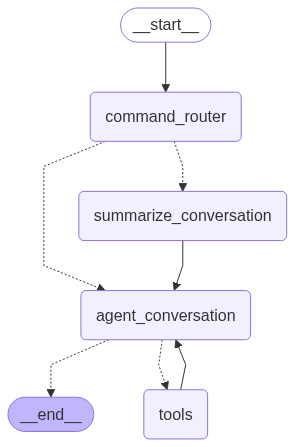

In [ ]:
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph_memory.get_graph(xray=True).draw_mermaid_png()))

Now lets invoke our agent with a simple question and see how it works.

In [ ]:
# Specify a thread, is it is used to keep track of the conversation history
config = {"configurable": {"thread_id": "1"}}
react_graph_memory.invoke({"messages": "hi, my name is martin"}, config)
react_graph_memory.invoke({"messages": "What is the remainder of 10 divided by 3 and what is the weather in Dallas, TX?"}, config)
react_graph_memory.invoke({"messages": "I have a dog named Teddy"}, config)
final_response = react_graph_memory.invoke({"messages": "what's my name?"}, config)


for m in final_response['messages']:
    m.pretty_print()


================================ Human Message =================================

what's my name?
================================ System Message ================================

Summary of conversation earlier: Summary of the conversation to date: Martin introduced himself and asked two questions: the remainder of 10 divided by 3, which was calculated to be 1, and the current weather in Dallas, TX, for which the information could not be provided
================================== Ai Message ==================================

Your name is Martin. How can I assist you today?


Wrap entire script below.

In [ ]:
os.environ.get("OPENAI_API_KEY")
os.environ.get("TAVILY_API_KEY") # API search engine tool

# Initialize the LLM

llm = init_chat_model(
    model = "gpt-4o-mini",
    model_provider="openai",
    temperature=0,
    max_tokens = 50
)

# tool used to search the web - useful for getting the latest information or data that the model may not have been trained
web_search_tool = TavilySearch(max_results=2)

# second tool is based on our own simple math function used to return the remainder of a division operation
def remainder(a: int, b: int) -> int:
    """returns the remainder of  a divided by b.

    Args:
        a: first int
        b: second int
    """
    return a % b


# Define the tools to be used by the LLM
tools = [web_search_tool, remainder]

llm_with_tools = llm.bind_tools(tools)

# System message | prompt engineering - assigning a role to the llm
sys_msg = SystemMessage(content="You are a helpful assistant that can use tools to answer questions. You can search the web and perform simple math operations. Use the tools when necessary.")

# Node - REACT agent
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# create our graph state
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# connect our nodes
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",  tools_condition)
builder.add_edge("tools", "assistant") # this edge connects the tools node back to the assistant node to return the results of the tool invocation in natural language format

# give our graph memory
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

# Specify a thread, is it is used to keep track of the conversation history
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="What is the remainder of 10 divided by 3 and what is the weather in Dallas, TX?")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config)
for m in messages['messages']:
    m.pretty_print()